<a href="https://colab.research.google.com/github/vankiee/ML_for_data_analysis/blob/main/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [161]:
import pandas as pd 
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RepeatedStratifiedKFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot

# Clean data

In [80]:
df = pd.read_csv('/content/gapminder.csv')
df[df.columns[1:]] = df.iloc[:, 1:].apply(pd.to_numeric, errors = 'coerce') 
dataset = df[df['lifeexpectancy'].notna()].reset_index(drop = True)
dataset

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,NaN,0.03,0.569653,26.8,7.594400e+07,25.600000,NaN,3.654122,48.673,NaN,0.0,NaN,6.684385,55.700001,24.04
1,Albania,1914.996551,7.29,1.024736,57.4,2.237473e+08,42.099998,NaN,44.989947,76.918,NaN,9.0,636.341383,7.699330,51.400002,46.72
2,Algeria,2231.993335,0.69,2.306817,23.5,2.932109e+09,31.700001,0.1,12.500073,73.131,0.420095,2.0,590.509814,4.848770,50.500000,65.22
3,Angola,1381.004268,5.57,1.461329,23.1,2.483580e+08,69.400002,2.0,9.999954,51.093,NaN,-2.0,172.999227,14.554677,75.699997,56.70
4,Argentina,10749.419238,9.35,0.560987,73.9,5.872119e+09,45.900002,0.5,36.000335,75.901,0.635944,8.0,768.428300,7.765584,58.400002,92.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,Vietnam,722.807559,3.91,1.085367,16.2,1.425435e+09,67.599998,0.4,27.851822,75.181,NaN,-7.0,302.725655,11.653322,71.000000,27.84
187,West Bank and Gaza,NaN,NaN,5.936085,NaN,1.424133e+07,11.300000,NaN,36.422772,72.832,NaN,NaN,NaN,NaN,32.000000,71.90
188,"Yemen, Rep.",610.357367,0.20,2.316235,35.1,2.348647e+08,20.299999,NaN,12.349750,65.493,NaN,-2.0,130.057831,6.265789,39.000000,30.64
189,Zambia,432.226337,3.56,0.341335,13.0,1.320257e+08,53.500000,13.5,10.124986,49.025,NaN,7.0,168.623031,12.019036,61.000000,35.42


In [81]:
dataset['lifeexpectancy'] = [1 if x >= 76.6 else 0 for x in dataset['lifeexpectancy']]

# Fitting Model

In [82]:
predictors = dataset[dataset.columns.drop(['country', 'lifeexpectancy'])]
target = dataset['lifeexpectancy']

### Strategies to fill NaN

mean Mean: 0.8899122807017542 SD: 0.07372831804335428
median Mean: 0.9005263157894736 SD: 0.07221083320481052
most_frequent Mean: 0.8987719298245612 SD: 0.06216594319794694
constant Mean: 0.9041228070175439 SD: 0.06488388425828083


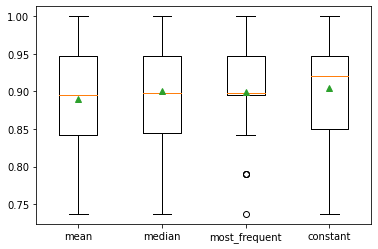

In [154]:
randomForest = RandomForestClassifier(n_estimators=25)
strategies = ['mean', 'median', 'most_frequent', 'constant']
results = []

for strategy in strategies:
  imputer = SimpleImputer(strategy=strategy)
  pipeline = Pipeline(steps=[('imputer', imputer), ('randomForest', randomForest)])
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  scores = cross_val_score(pipeline, predictors, target, cv=cv, scoring='accuracy', n_jobs=-1)
  results.append(scores)
  print(strategy, 'Mean:', np.mean(scores), 'SD:', np.std(scores))

pyplot.boxplot(results, labels=strategies, showmeans=True)
pyplot.show()

### Fitting random forest

In [150]:
randomForest = RandomForestClassifier(n_estimators=25)
imputer = SimpleImputer(strategy='median')
pipeline = Pipeline(steps=[('imputer', imputer), ('randomForest', randomForest)])
predictions = cross_val_predict(pipeline, predictors, target, cv=10)
print('accuracy:', metrics.accuracy_score(target, predictions))
metrics.confusion_matrix(target, predictions)

accuracy: 0.9109947643979057


array([[136,   7],
       [ 10,  38]])

### Finding feature importance rank

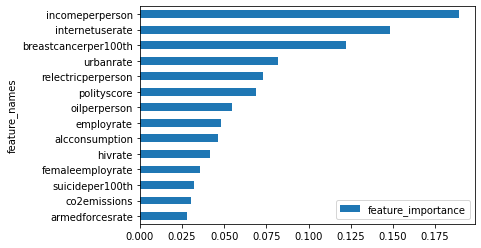

In [145]:
extraTree = ExtraTreesClassifier()
imputer = SimpleImputer(strategy='median')
pipeline = Pipeline(steps=[('imputer', imputer), ('extraTree', extraTree)])

pipeline.fit(predictors, target)
features = list(zip(predictors, pipeline.named_steps['extraTree'].feature_importances_))

featuresDf = pd.DataFrame(features).rename(columns={0: 'feature_names', 
                                                    1: 'feature_importance'}).set_index('feature_names')

_ = featuresDf.sort_values(by='feature_importance').plot.barh(orientation='horizontal')

# See effect of different number of trees on prediction accuracy

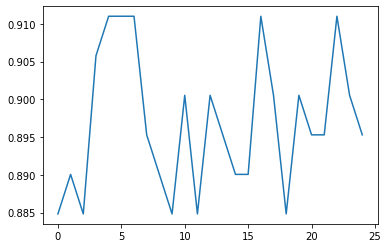

In [163]:
trees = range(25)
accuracy = np.zeros(25)

for idx in range(len(trees)):
  classifier = RandomForestClassifier(n_estimators=idx+1)
  pipeline = Pipeline(steps=[('i', SimpleImputer(strategy='median')),
                              ('m', RandomForestClassifier())])
  predictions = cross_val_predict(pipeline, predictors, target, cv=10)
  accuracy[idx] = metrics.accuracy_score(target, predictions)

plt.plot(trees, accuracy)

# Conclusion

The explanatory variables with the highest relative importance scores were income per person, internet use rate, breast cancer per 100,000 female, and urban rate. The accuracy of the random forest was 91%. 4-5 trees suffice to reach high prediction accuracy.